# Client orders :: *ipynb solution draft* <br>

## Read Data

In [1]:
# Import libraries

import order_functions as of

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import re

from persiantools import jdatetime

from scipy.stats import boxcox
from scipy.stats import ttest_ind

from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Read data / Clean version of sales_data.csv

df = pd.read_csv("sales_data_clean.csv")
df.head()

,Order_ID,Branch,Order_Date,Order_Priority,Manufacturer,Model_Name,Category,Screen_Size,RAM,OS,...,CPU_GHZ,Storage_SSD,Storage_HDD,Storage_Hybrid,Storage_Flash,Storage_Total,GPU_Brand,GPU_Model,Rating,Store
0,0,Hamedan,1396-10-26,H,Dell,Vostro 3568,Notebook,15.6,8,Windows,...,2.5,256,0,0,0,256,AMD,Radeon R5 M420,NaN,NaN
1,1,Kermanshah,1394-04-21,H,Lenovo,Yoga 720-13IKB,2 in 1 Convertible,13.3,8,Windows,...,2.5,256,0,0,0,256,Intel,HD Graphics 620,NaN,NaN
2,2,Rasht,1402-05-24,M,Lenovo,IdeaPad Y700-15ISK,Notebook,15.6,8,Windows,...,2.6,0,1024,0,0,1024,Nvidia,GeForce GTX 960M,NaN,NaN
3,3,Kermanshah,1397-06-17,H,Dell,Inspiron 5370,Ultrabook,13.3,8,Windows,...,1.8,256,0,0,0,256,AMD,Radeon 530,NaN,NaN
4,4,Karaj,1392-09-30,L,Acer,Aspire E5-576G,Notebook,15.6,4,Windows,...,2.5,256,0,0,0,256,Nvidia,GeForce 940MX,NaN,NaN


In [3]:
# Convert Shamsi dates to Miladi

def vectorized_convert_shamsi_to_datetime(years, months, days):
    gregorian_dates = [
        jdatetime.JalaliDate(int(y), int(m), int(d)).to_gregorian()
        for y, m, d in zip(years, months, days)
    ]
    return pd.to_datetime(gregorian_dates)

years, months, days = zip(*df["Order_Date"].str.split("-").tolist())
df["Order_Date"] = vectorized_convert_shamsi_to_datetime(years, months, days)
df.head()

,Order_ID,Branch,Order_Date,Order_Priority,Manufacturer,Model_Name,Category,Screen_Size,RAM,OS,...,CPU_GHZ,Storage_SSD,Storage_HDD,Storage_Hybrid,Storage_Flash,Storage_Total,GPU_Brand,GPU_Model,Rating,Store
0,0,Hamedan,2018-01-16,H,Dell,Vostro 3568,Notebook,15.6,8,Windows,...,2.5,256,0,0,0,256,AMD,Radeon R5 M420,NaN,NaN
1,1,Kermanshah,2015-07-12,H,Lenovo,Yoga 720-13IKB,2 in 1 Convertible,13.3,8,Windows,...,2.5,256,0,0,0,256,Intel,HD Graphics 620,NaN,NaN
2,2,Rasht,2023-08-15,M,Lenovo,IdeaPad Y700-15ISK,Notebook,15.6,8,Windows,...,2.6,0,1024,0,0,1024,Nvidia,GeForce GTX 960M,NaN,NaN
3,3,Kermanshah,2018-09-08,H,Dell,Inspiron 5370,Ultrabook,13.3,8,Windows,...,1.8,256,0,0,0,256,AMD,Radeon 530,NaN,NaN
4,4,Karaj,2013-12-21,L,Acer,Aspire E5-576G,Notebook,15.6,4,Windows,...,2.5,256,0,0,0,256,Nvidia,GeForce 940MX,NaN,NaN


---

## Client Oder #4

در آینده‌ای نزدیک شرکت می‌خواهد لپ‌تاپ‌های جدیدی را وارد کند و از شما می‌خواهد تا بگویید سرمایه خود را به چه نحوی بین برند‌ها و دسته‌بندی‌های مختلف لپ‌تاپ تقسیم کند.

In [4]:
# Filter columns needed for analysis and create a new dataframe

cols_for_analyze_4 = [
    "Order_Date",
    "Order_Priority",
    "Manufacturer",
    "Category",
    "Price",
    "Total_Price",
    "Quantity",
    "Profit",
]

df4 = df[cols_for_analyze_4].copy()
df4.head()

,Order_Date,Order_Priority,Manufacturer,Category,Price,Total_Price,Quantity,Profit
0,2018-01-16,H,Dell,Notebook,3450000,3450000,1,250000
1,2015-07-12,H,Lenovo,2 in 1 Convertible,3400000,3400000,1,380000
2,2023-08-15,M,Lenovo,Notebook,44900000,44900000,1,5630000
3,2018-09-08,H,Dell,Ultrabook,12550000,12550000,1,1130000
4,2013-12-21,L,Acer,Notebook,2050000,2050000,1,180000


In [5]:
# Modify columns to: "Profit per device": 'Profit', and "Total Order Profit": 'Total_Profit'

df4["Profit"] = df4["Profit"] / df4["Quantity"]
df4["Total_Profit"] = df4["Profit"] * df4["Quantity"]

df4.head()

,Order_Date,Order_Priority,Manufacturer,Category,Price,Total_Price,Quantity,Profit,Total_Profit
0,2018-01-16,H,Dell,Notebook,3450000,3450000,1,250000.0,250000.0
1,2015-07-12,H,Lenovo,2 in 1 Convertible,3400000,3400000,1,380000.0,380000.0
2,2023-08-15,M,Lenovo,Notebook,44900000,44900000,1,5630000.0,5630000.0
3,2018-09-08,H,Dell,Ultrabook,12550000,12550000,1,1130000.0,1130000.0
4,2013-12-21,L,Acer,Notebook,2050000,2050000,1,180000.0,180000.0


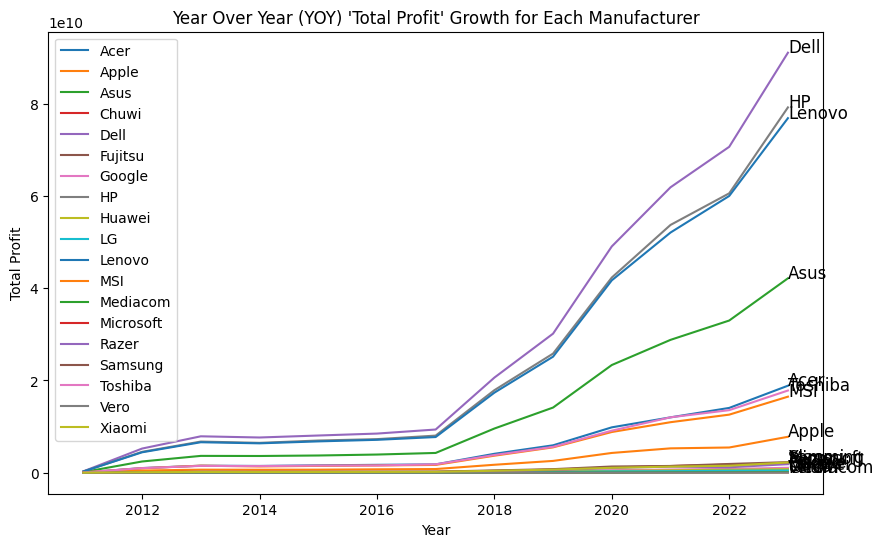

In [6]:
# Add column 'Year', Group by 'Year' & 'Manufacturer', & Plot YOY growth of Total Profit for each manufacturer

df4["Year"] = df4["Order_Date"].dt.year

df4_yoy_Manufacturer = (
    df4.groupby(["Year", "Manufacturer"]).agg({"Total_Profit": "sum"}).reset_index()
)
df4_yoy_Manufacturer = df4_yoy_Manufacturer.pivot(
    index="Manufacturer", columns="Year", values="Total_Profit"
)

fig, ax = plt.subplots(figsize=(10, 6))
for manufacturer in df4_yoy_Manufacturer.index:
    ax.plot(
        df4_yoy_Manufacturer.columns,
        df4_yoy_Manufacturer.loc[manufacturer],
        label=manufacturer,
    )
    ax.text(
        df4_yoy_Manufacturer.columns[-1],
        df4_yoy_Manufacturer.loc[manufacturer, df4["Year"].max()],
        manufacturer,
        fontsize=12,
    )
ax.set_title("Year Over Year (YOY) 'Total Profit' Growth for Each Manufacturer")
ax.set_xlabel("Year")
ax.set_ylabel("Total Profit")
ax.legend()
plt.show()

**Dell**, **HP**, **Lenovo** & **ASUS** are the brands with most total profit over the years.

In [7]:
# List of top manufacturers by total profit

total_profit_by_brand = (
    df4.groupby("Manufacturer")["Total_Profit"].sum().sort_values(ascending=False)
)

total_profit_by_brand

Manufacturer
Dell         3.704426e+11
HP           3.198779e+11
Lenovo       3.125165e+11
Asus         1.728327e+11
Acer         7.398900e+10
Toshiba      7.087452e+10
MSI          6.670011e+10
Apple        3.112172e+10
Samsung      9.467740e+09
Microsoft    8.490480e+09
Xiaomi       8.220260e+09
Razer        7.176360e+09
Google       4.200320e+09
Fujitsu      3.449380e+09
Huawei       3.224240e+09
LG           2.098290e+09
Mediacom     4.936100e+08
Chuwi        3.003900e+08
Vero         1.253600e+08
Name: Total_Profit, dtype: float64

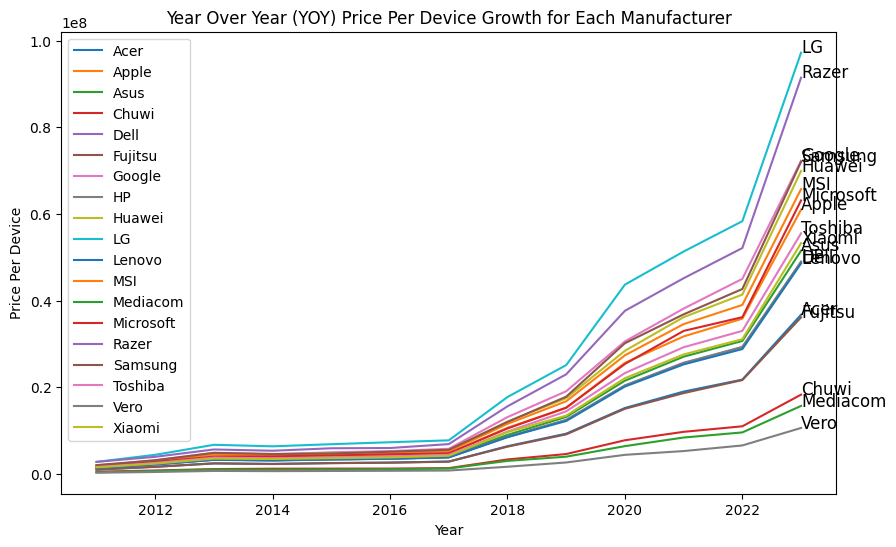

In [8]:
# Add column 'Year', Group by 'Year' & 'Manufacturer', & Plot YOY growth pf profit per device for each manufacturer

df4_yoy_Manufacturer = (
    df4.groupby(["Year", "Manufacturer"]).agg({"Price": "mean"}).reset_index()
)
df4_yoy_Manufacturer = df4_yoy_Manufacturer.pivot(
    index="Manufacturer", columns="Year", values="Price"
)

fig, ax = plt.subplots(figsize=(10, 6))
for manufacturer in df4_yoy_Manufacturer.index:
    ax.plot(
        df4_yoy_Manufacturer.columns,
        df4_yoy_Manufacturer.loc[manufacturer],
        label=manufacturer,
    )
    ax.text(
        df4_yoy_Manufacturer.columns[-1],
        df4_yoy_Manufacturer.loc[manufacturer, df4["Year"].max()],
        manufacturer,
        fontsize=12,
    )
ax.set_title("Year Over Year (YOY) Price Per Device Growth for Each Manufacturer")
ax.set_xlabel("Year")
ax.set_ylabel("Price Per Device")
ax.legend()
plt.show()

**LG**, **Razor**, **Google** & **Samsung** are the brands with increase in profit per device and seem emerging.

In [9]:
# List of top manufacturers by price per device

price_by_brand = (
    df4.groupby("Manufacturer")["Price"].mean().sort_values(ascending=False)
)

price_by_brand

Manufacturer
LG           2.577851e+07
Razer        2.360394e+07
Google       2.020352e+07
Samsung      1.869120e+07
Huawei       1.791272e+07
MSI          1.724588e+07
Microsoft    1.662286e+07
Apple        1.594372e+07
Toshiba      1.491629e+07
Xiaomi       1.427246e+07
Asus         1.369611e+07
HP           1.296945e+07
Dell         1.293588e+07
Lenovo       1.282996e+07
Acer         9.761597e+06
Fujitsu      9.543999e+06
Chuwi        4.930607e+06
Mediacom     4.171304e+06
Vero         2.766945e+06
Name: Price, dtype: float64

Suggested Allocation by Brands:

- Top 3 brands (Dell, HP, Lenovo): Allocate 50% of funds.<br>
    Dell: 20%, HP: 15%, Lenovo: 15%.
- Next 4-7 brands (ASUS, Acer, TOSHIBA, MSI, Apple): Allocate 25% of evenly.
- Remaining brands: Allocate the remaining 25%.
    Prioritize emerging brands like LG, Razer, and Google.


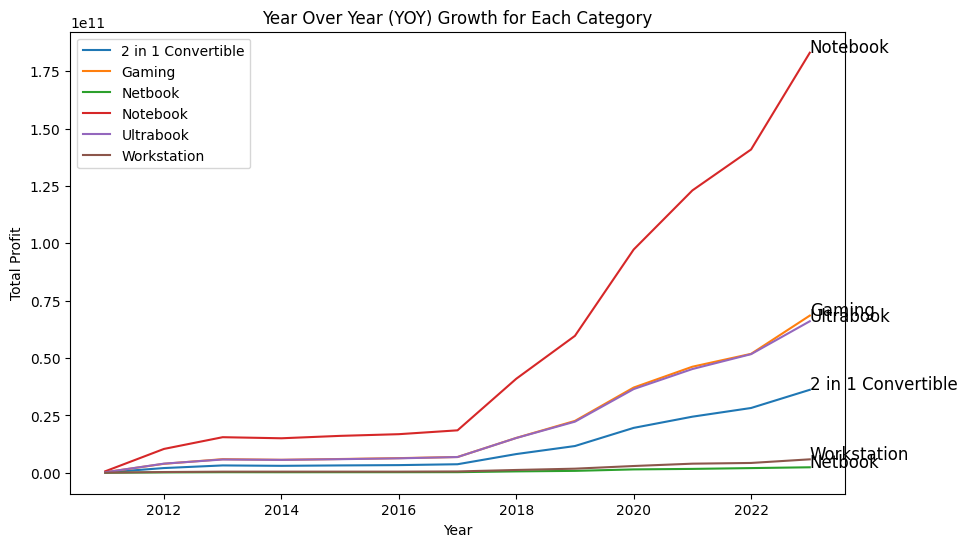

In [10]:
# Add column 'Year', Group by 'Year' & 'Category', & Plot YOY growth of Total Profit for each category

df4_yoy_category = (
    df4.groupby(["Year", "Category"]).agg({"Total_Profit": "sum"}).reset_index()
)
df4_yoy_category = df4_yoy_category.pivot(
    index="Category", columns="Year", values="Total_Profit"
)

fig, ax = plt.subplots(figsize=(10, 6))
for category in df4_yoy_category.index:
    ax.plot(df4_yoy_category.columns, df4_yoy_category.loc[category], label=category)
    ax.text(
        df4_yoy_category.columns[-1],
        df4_yoy_category.loc[category, df4["Year"].max()],
        category,
        fontsize=12,
    )
ax.set_title("Year Over Year (YOY) Growth for Each Category")
ax.set_xlabel("Year")
ax.set_ylabel("Total Profit")
ax.legend()
plt.show()

In [11]:
# List of top categories by total profit

total_profit_by_category = (
    df4.groupby("Category")["Total_Profit"].sum().sort_values(ascending=False)
)

total_profit_by_category

Category
Notebook              7.380291e+11
Gaming                2.763986e+11
Ultrabook             2.714495e+11
2 in 1 Convertible    1.467489e+11
Workstation           2.275983e+10
Netbook               1.021573e+10
Name: Total_Profit, dtype: float64

**Notebook**, **Gaming**, & **Ultrabook** are the best performing laptop categories.

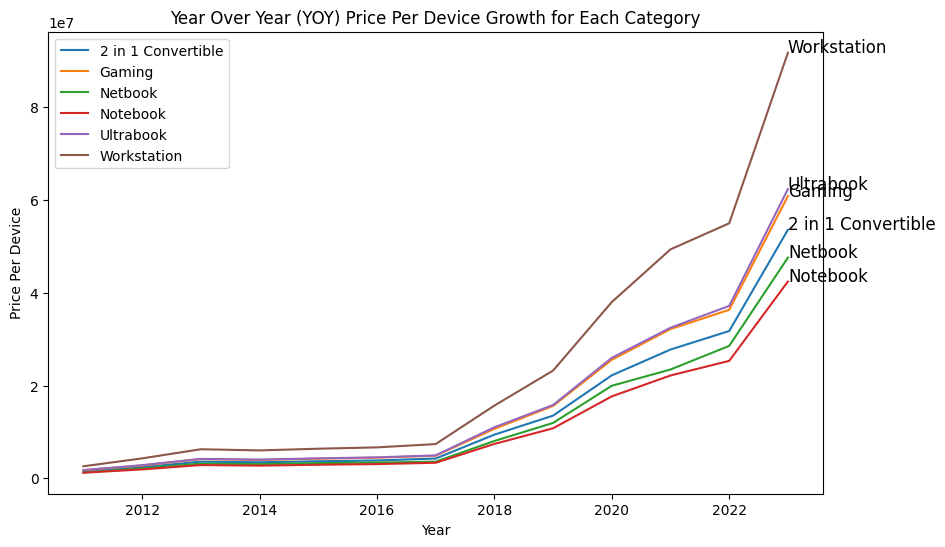

In [12]:
# Add column 'Year', Group by 'Year' & 'Category', & Plot YOY growth pf profit per device for each category

df4_yoy_Category = (
    df4.groupby(["Year", "Category"]).agg({"Price": "mean"}).reset_index()
)
df4_yoy_Category = df4_yoy_Category.pivot(
    index="Category", columns="Year", values="Price"
)

fig, ax = plt.subplots(figsize=(10, 6))
for category in df4_yoy_Category.index:
    ax.plot(df4_yoy_Category.columns, df4_yoy_Category.loc[category], label=category)
    ax.text(
        df4_yoy_Category.columns[-1],
        df4_yoy_Category.loc[category, df4["Year"].max()],
        category,
        fontsize=12,
    )
ax.set_title("Year Over Year (YOY) Price Per Device Growth for Each Category")
ax.set_xlabel("Year")
ax.set_ylabel("Price Per Device")
ax.legend()
plt.show()

In [13]:
# List of top categories by price per device

price_by_category = df4.groupby("Category")["Price"].mean().sort_values(ascending=False)

price_by_category

Category
Workstation           2.486757e+07
Ultrabook             1.644058e+07
Gaming                1.623699e+07
2 in 1 Convertible    1.411108e+07
Netbook               1.234426e+07
Notebook              1.123027e+07
Name: Price, dtype: float64

**Workstation** & **Ultrabook** & **Gaming** are the brands with increase in profit per device and seem emerging.

Suggested Allocation by Categories:

- Notebook: $40%
- Ultrabook & Gaming: 20% each
- 20% for remaining categories


---